In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/Deep Learning/classification_dataset.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/drive/MyDrive/Deep Learning")

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1./255.)




train_flow = train_gen.flow_from_directory(directory = '/content/drive/MyDrive/Deep Learning/Nouveau dossier',
                                           target_size=(256, 256),
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=8,
                                           seed=54,
                                           subset='training')



val_flow = val_gen.flow_from_directory(directory = '/content/drive/MyDrive/Deep Learning/Nouveau dossier',
                                           target_size=(256, 256),
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=8,
                                           seed=54,
                                           subset='validation')





classes_names = train_flow.class_indices

Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [2]:
classes_names

{'Ecrou NOK': 0,
 'Ecrou OK': 1,
 'Rondelle NOK': 2,
 'Rondelle OK': 3,
 'Vis NOK': 4,
 'Vis OK': 5}

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights="imagenet")

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(6, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(
              lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr * (epoch + 1) / 5
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(lr_scheduler)





history = model.fit(
    train_flow,
    epochs=30,
    batch_size=8,
    validation_data=val_flow,
    callbacks=[lr_schedule]
)



Epoch 1/30
300/300 [==============================] - 75s 179ms/step - loss: 1.2063 - accuracy: 0.5921 - val_loss: 4.1184 - val_accuracy: 0.1950 - lr: 2.0000e-04
Epoch 2/30
300/300 [==============================] - 53s 177ms/step - loss: 0.7936 - accuracy: 0.7588 - val_loss: 3.0329 - val_accuracy: 0.3700 - lr: 8.0000e-05
Epoch 3/30
300/300 [==============================] - 54s 180ms/step - loss: 0.7334 - accuracy: 0.7588 - val_loss: 3.1554 - val_accuracy: 0.3750 - lr: 4.8000e-05
Epoch 4/30
300/300 [==============================] - 53s 176ms/step - loss: 0.6311 - accuracy: 0.7750 - val_loss: 1.5616 - val_accuracy: 0.5917 - lr: 3.8400e-05
Epoch 5/30
300/300 [==============================] - 55s 185ms/step - loss: 0.6026 - accuracy: 0.7867 - val_loss: 1.5141 - val_accuracy: 0.6467 - lr: 3.8400e-05
Epoch 6/30
300/300 [==============================] - 53s 175ms/step - loss: 0.5891 - accuracy: 0.7667 - val_loss: 1.2986 - val_accuracy: 0.6700 - lr: 3.4746e-05
Epoch 7/30
300/300 [========

75/75 [==============================] - 2s 27ms/step
Confusion Matrix: [[24 14 16 13  6 27]
 [18 22 15 17 15 13]
 [20 12 19 16 12 21]
 [12 11 27 13 13 24]
 [17 15 21  9 16 22]
 [19 17 13 17 13 21]]


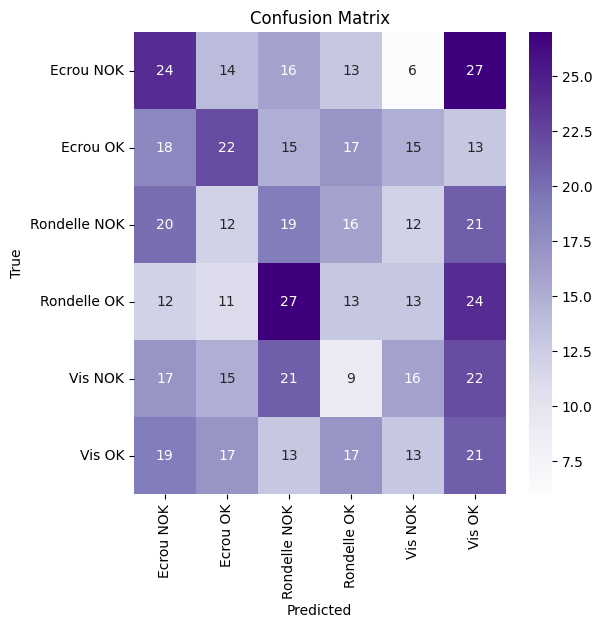

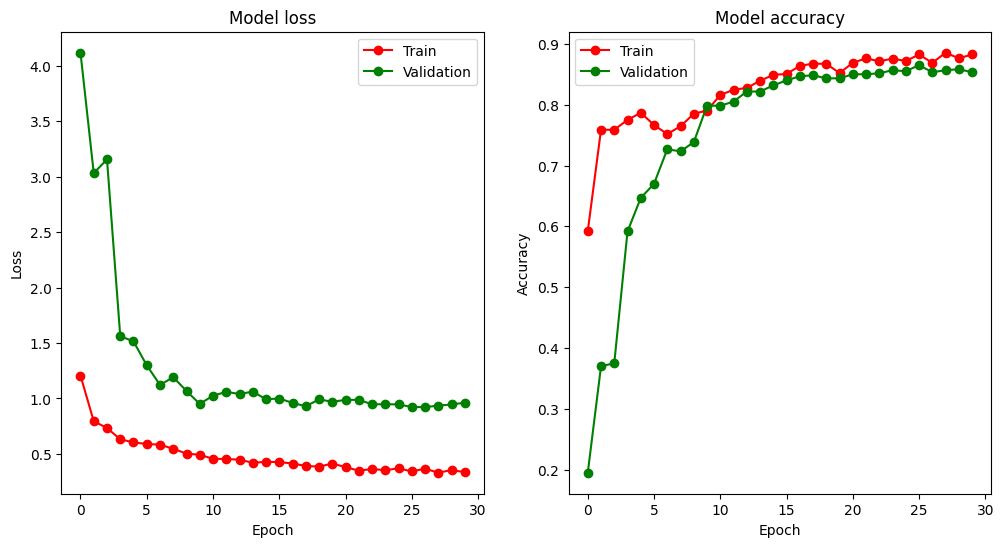

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:

val_predictions = model.predict(val_flow)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = val_flow.classes



confusion_mtx = confusion_matrix(val_true_classes, val_pred_classes)
print('Confusion Matrix:', confusion_mtx)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, cmap='Purples',
            xticklabels=val_flow.class_indices.keys(),
            yticklabels=val_flow.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], c='r', marker='o')
plt.plot(history.history['val_loss'], c='g', marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], c='r',  marker='o')
plt.plot(history.history['val_accuracy'], c='g',  marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.show()


model.save('improved_classification_model.h5')